<a href="https://colab.research.google.com/github/alxkzncoff/skillfactory_rds6_car_price_prediction_ml_dl/blob/main/model/blend_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSATLL

In [1]:
!pip install PyDrive
!mkdir work_dir
!pip install -q -U keras-tuner
!pip install catboost

     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 66.2MB 44kB/s 


# DEFINE

In [2]:
DATA_PATH                           = '/content/work_dir'
RANDOM_SEED                         = 42

# INPUT

In [3]:
# Data access
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# General
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import sys
import PIL
import cv2
import re
import IPython
from tqdm.notebook import tqdm

# ml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import lognorm
from scipy.stats import shapiro
from sklearn.model_selection import StratifiedKFold, KFold
from catboost import CatBoostRegressor
from catboost import Pool
from catboost import cv

# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
import kerastuner as kt

# DOWNLOAD DATA

In [4]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
# Download clear_train.csv from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1-3kiZxEddvuNFoRTfMA6cA8bu7LjP2b3"}) # откуда берем файл
downloaded.GetContentFile(DATA_PATH+'/clear_train.csv') # куда сохраняем файл в вирутальной машине колаба

# Download clear_test.csv from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1-0yG59TcpJoDSeOclid1z-nc1Fh3yud2"})
downloaded.GetContentFile(DATA_PATH+'/clear_test.csv')

# Download sample_submission from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1Edwuioev6uEyeXuCQuloPNQ70V5-3HZG"})
downloaded.GetContentFile(DATA_PATH+'/sample_submission.csv')

# ML CatBoost

In [6]:
train = pd.read_csv(DATA_PATH+'/clear_train.csv')
test = pd.read_csv(DATA_PATH+'/clear_test.csv')
sample_submission = pd.read_csv(DATA_PATH+'/sample_submission.csv')

In [7]:
train.num_of_doors = train.num_of_doors.astype(str)
test.num_of_doors = test.num_of_doors.astype(str)

## PREPARING

In [8]:
df = pd.concat([train, test])

In [9]:
df.price.fillna(0, inplace=True)
df['sample'] = df.price.apply(lambda x:0 if x == 0 else 1)

In [10]:
def data_prep(df):

  categorical_features = ['body', 'brand', 'color', 'fuel', 'model_info', 'name',  'num_of_doors',  'transmission', 'owners', 'vehicle_title', 'drive_type']
  numerical_features = ['engine_displacement', 'engine_power', 'mileage', 'model_date', 'production_date', 'tax', 'days_in_use']

  # ############################### Normalization ######################################
  MMS = MinMaxScaler()

  MMS.fit(df[numerical_features])
  df[numerical_features] = MMS.transform(df[numerical_features])

  return df, categorical_features 

In [11]:
df, cat_features = data_prep(df)
df.shape

(8353, 22)

## SPLIT

In [12]:
X = df.query('sample==1').drop(columns=['description', 'price', 'sample', 'sell_id'])
y = df.query('sample==1').price.values
test = df.query('sample==0').drop(columns=['description', 'price', 'sample', 'sell_id'])

# ############ Split #################
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

In [13]:
train_data = Pool(data = X_train,
                  label = y_train,
                  cat_features =  cat_features)

test_data = Pool(data = X_test,
                 label = y_test,
                  cat_features =  cat_features)

## MODEL

In [14]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [15]:
ctb = CatBoostRegressor( loss_function = 'MAE',
                         eval_metric = 'MAPE',
                         learning_rate=0.002,
                         iterations=30000, # обучаем до overfitting'a
                         l2_leaf_reg=2,
                         depth=5,
                         bootstrap_type = 'Bernoulli', # Bayesian Bernoulli
                         one_hot_max_size = 360,
                         random_seed=RANDOM_SEED,
                         od_type='Iter',
                         od_wait=500,
                         task_type='CPU')


ml_model = ctb.fit(train_data,
                eval_set=test_data,
                verbose_eval=500,
                use_best_model=True)
#                plot=True)
print(ml_model)

test_predict_cat = ml_model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_cat))*100:0.2f}%")

0:	learn: 0.6290616	test: 0.6430650	best: 0.6430650 (0)	total: 48.9ms	remaining: 24m 27s
500:	learn: 0.3211629	test: 0.3252184	best: 0.3252184 (500)	total: 1.12s	remaining: 1m 5s
1000:	learn: 0.2137563	test: 0.2141180	best: 0.2141180 (1000)	total: 2.16s	remaining: 1m 2s
1500:	learn: 0.1732567	test: 0.1731448	best: 0.1731448 (1500)	total: 3.2s	remaining: 1m
2000:	learn: 0.1562711	test: 0.1557745	best: 0.1557745 (2000)	total: 4.23s	remaining: 59.1s
2500:	learn: 0.1472348	test: 0.1463100	best: 0.1463100 (2500)	total: 5.29s	remaining: 58.2s
3000:	learn: 0.1410992	test: 0.1399390	best: 0.1399390 (3000)	total: 6.31s	remaining: 56.8s
3500:	learn: 0.1368810	test: 0.1351242	best: 0.1351242 (3500)	total: 7.33s	remaining: 55.5s
4000:	learn: 0.1335575	test: 0.1319117	best: 0.1319117 (4000)	total: 8.35s	remaining: 54.3s
4500:	learn: 0.1306541	test: 0.1291945	best: 0.1291945 (4500)	total: 9.4s	remaining: 53.2s
5000:	learn: 0.1280759	test: 0.1269137	best: 0.1269137 (5000)	total: 10.4s	remaining: 52s


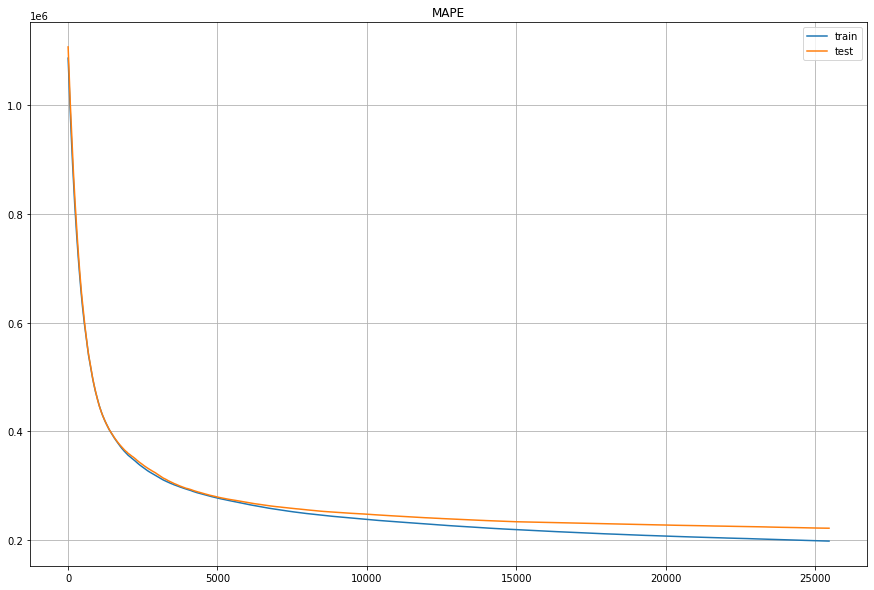

In [16]:
plt.figure(figsize=(15,10))
plt.title('MAPE')
plt.plot(ml_model.evals_result_['learn']['MAE'], label='train')
plt.plot(ml_model.evals_result_['validation']['MAE'], label='test')
plt.legend()
plt.grid()
plt.show()

## PREDICT

In [17]:
predict_data = Pool(data = test,
                    cat_features =  cat_features)

ml_predict = ml_model.predict(predict_data)

In [18]:
sample_submission_ml = pd.DataFrame(columns=['price'])
sample_submission_ml['price'] = sample_submission['price']
sample_submission_ml['price'] = ml_predict
sample_submission_ml.to_csv(DATA_PATH+f'/sub_cat_{round((mape(y_test, test_predict_cat)*100),2)}.csv'.replace('.', '_', 1), index=False)
display(sample_submission_ml.head(10))

,price
0,5.751651e+05
1,2.606512e+06
2,6.487584e+05
3,4.739163e+05
4,2.648820e+06
5,3.126302e+06
6,1.594280e+06
7,1.160705e+06
8,1.068080e+06
9,5.011271e+05


# NN

## PREPARING

In [19]:
train = pd.read_csv(DATA_PATH+'/clear_train.csv')
test = pd.read_csv(DATA_PATH+'/clear_test.csv')

In [20]:
df = pd.concat([train, test])

In [21]:
df.price.fillna(0, inplace=True)
df['sample'] = df.price.apply(lambda x:0 if x == 0 else 1)

In [22]:
# ##################### Логорифмируем ######################
df.engine_displacement = df.engine_displacement.max() - np.log(df.engine_displacement)
df.engine_power = df.engine_power.max() - np.log(df.engine_power)

In [23]:
def data_prep(df):

  categorical_features = ['body', 'brand', 'color', 'fuel', 'model_info', 'name',  'num_of_doors',  'transmission', 'owners', 'vehicle_title', 'drive_type']
  numerical_features = ['engine_displacement', 'engine_power', 'mileage', 'model_date', 'production_date', 'tax', 'days_in_use']

  # ############################## Label Encoding #####################################
  for column in categorical_features:
      df[column] = df[column].astype('category').cat.codes
  
  # ############################### One Hot encoding ###################################
  df = pd.get_dummies(df, columns=categorical_features, dummy_na=False)

  # ############################### Normalization ######################################
  MMS = MinMaxScaler()

  MMS.fit(df[numerical_features])
  df[numerical_features] = MMS.transform(df[numerical_features])

  return df

In [24]:
df = data_prep(df)
df.shape

(8353, 546)

## SPLIT

In [25]:
X = df.query('sample==1').drop(columns=['description', 'price', 'sample', 'sell_id'])
y = df.query('sample==1').price.values
test = df.query('sample==0').drop(columns=['description', 'price', 'sample', 'sell_id'])

# ############ Split #################
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

## MODEL

In [26]:
def build_model(LR, EPOCHS, OPTIMIZER_TYPE):

  # ######################### Create simple neural network #############################
  nn_model = Sequential()
  nn_model.add(L.Dense(1090, input_dim=X_train.shape[1], activation="relu", name='dense_1090'))
  nn_model.add(L.Dropout(0.85))
  nn_model.add(L.Dense(545, activation="relu", name='dense_545'))
  nn_model.add(L.Dense(1, activation="linear", name='output_dense_1'))

  display(nn_model.summary())

  plt.figure(figsize=(20,15))
  plot_model(nn_model, to_file=DATA_PATH+'/model_plot.png', show_shapes=True, show_layer_names=True)
  img = mpimg.imread(DATA_PATH+'/model_plot.png')
  plt.imshow(img)
  plt.show()

  # ######################### Optimizer ##############################
  if OPTIMIZER_TYPE == 'Adam':
    optimizer = tf.keras.optimizers.Adam(LR)
  elif OPTIMIZER_TYPE == 'Adamax':
    optimizer = tf.keras.optimizers.Adamax(LR)

  nn_model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

  # ######################## Checkpoints #############################
  checkpoint = ModelCheckpoint(DATA_PATH+'/best_model.hdf5' , monitor='val_MAPE', verbose=0  , mode='min', save_best_only=True)
  earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
  callbacks_list = [checkpoint, earlystop]

  # ######################## Fit model ##############################
  history = nn_model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0
                   )
  
  # ######################## Saving best model #####################
  nn_model.load_weights(DATA_PATH+'/best_model.hdf5')
  nn_model.save(DATA_PATH+'/nn_1.hdf5')

  # ######################## Show results ###########################
  plt.figure(figsize=(15,10))
  plt.title('Loss')
  plt.plot(history.history['MAPE'], label='train')
  plt.plot(history.history['val_MAPE'], label='test')
  plt.legend()
  plt.grid()
  plt.show()

  test_predict_nn = nn_model.predict(X_test)
  print(f"TEST mape: {(mape(y_test, test_predict_nn[:,0]))*100:0.2f}%")

  return nn_model, checkpoint, earlystop, callbacks_list, history, test_predict_nn

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1090 (Dense)           (None, 1090)              591870    
_________________________________________________________________
dropout (Dropout)            (None, 1090)              0         
_________________________________________________________________
dense_545 (Dense)            (None, 545)               594595    
_________________________________________________________________
output_dense_1 (Dense)       (None, 1)                 546       
Total params: 1,187,011
Trainable params: 1,187,011
Non-trainable params: 0
_________________________________________________________________


None

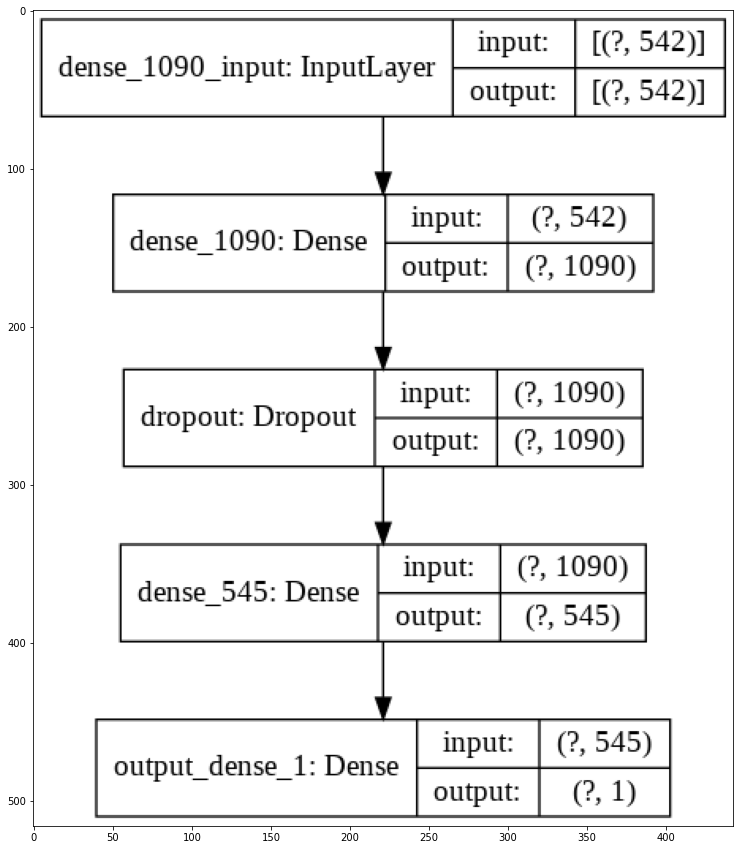

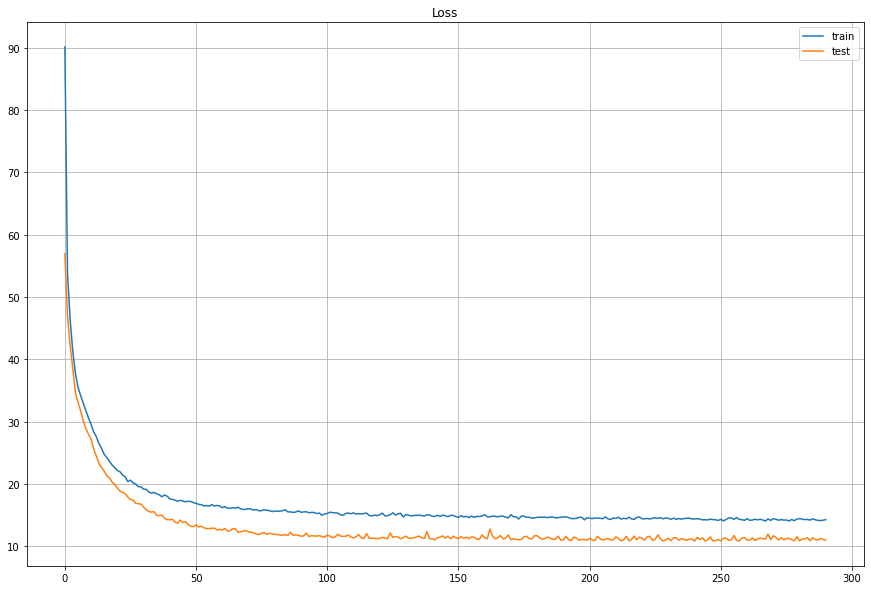

TEST mape: 10.86%


In [27]:
nn_model, checkpoint, earlystop, callbacks_list, history, test_predict_nn = build_model(LR=0.1, EPOCHS=2000, OPTIMIZER_TYPE='Adamax')

## PREDICT

In [28]:
nn_predict = nn_model.predict(test)

In [30]:
sample_submission_nn = pd.DataFrame(columns=['price'])
sample_submission_nn['price'] = sample_submission['price']
sample_submission_nn['price'] = nn_predict
sample_submission_nn.to_csv(DATA_PATH+f'/sub_nn_{round((mape(y_test, test_predict_nn[:,0])*100),2)}.csv'.replace('.', '_', 1), index=False)
display(sample_submission_nn.head(10))

,price
0,4.932820e+05
1,2.580260e+06
2,6.659696e+05
3,5.034076e+05
4,2.727043e+06
5,3.046926e+06
6,1.614375e+06
7,1.532765e+06
8,1.096277e+06
9,5.048557e+05


# BLEND

In [32]:
test_blend_predict = (test_predict_cat + test_predict_nn[:,0]) / 2

TEST mape: 10.30%


In [38]:
sample_submission_blend = pd.DataFrame(columns=['sell_id','price'])
sample_submission_blend[['sell_id','price']] = sample_submission[['sell_id','price']]
blend_predict = (ml_predict + nn_predict[:,0]) / 2
sample_submission_blend['price'] = blend_predict
sample_submission_blend.to_csv(DATA_PATH+f'/sub_blend.csv', index=False)
sample_submission_blend.head(10)

,sell_id,price
0,1099427284,5.342236e+05
1,1096405886,2.593386e+06
2,1100195294,6.573640e+05
3,1099827282,4.886620e+05
4,1100076198,2.687931e+06
5,1090159352,3.086614e+06
6,1098987386,1.604327e+06
7,1098639040,1.346735e+06
8,1099933039,1.082179e+06
9,1099565572,5.029914e+05


# CROSS VALIDATION

## ML

In [43]:
train = pd.read_csv(DATA_PATH+'/clear_train.csv')
test = pd.read_csv(DATA_PATH+'/clear_test.csv')
train.num_of_doors = train.num_of_doors.astype(str)
test.num_of_doors = test.num_of_doors.astype(str)

### PREPARING

In [44]:
df = pd.concat([train, test])

df.price.fillna(0, inplace=True)
df['sample'] = df.price.apply(lambda x:0 if x == 0 else 1)

def data_prep(df):

  categorical_features = ['body', 'brand', 'color', 'fuel', 'model_info', 'name',  'num_of_doors',  'transmission', 'owners', 'vehicle_title', 'drive_type']
  numerical_features = ['engine_displacement', 'engine_power', 'mileage', 'model_date', 'production_date', 'tax', 'days_in_use']

  # ############################### Normalization ######################################
  MMS = MinMaxScaler()

  MMS.fit(df[numerical_features])
  df[numerical_features] = MMS.transform(df[numerical_features])

  return df, categorical_features 

df, cat_features = data_prep(df)
df.shape

(8353, 22)

### SPLIT

In [45]:
X = df.query('sample==1').drop(columns=['description', 'price', 'sample', 'sell_id'])
y = df.query('sample==1').price.values
test = df.query('sample==0').drop(columns=['description', 'price', 'sample', 'sell_id'])

# ############ Split #################
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

train_data = Pool(data = X_train,
                  label = y_train,
                  cat_features =  cat_features)

test_data = Pool(data = X_test,
                 label = y_test,
                  cat_features =  cat_features)

### MODEL

In [46]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor( loss_function = 'MAE',
                         eval_metric = 'MAPE',
                         learning_rate=0.002,
                         iterations=30000, # обучаем до overfitting'a
                         l2_leaf_reg=2,
                         depth=5,
                         bootstrap_type = 'Bernoulli', # Bayesian Bernoulli
                         one_hot_max_size = 360,
                         random_seed=RANDOM_SEED,
                         od_type='Iter',
                         od_wait=500,
                         task_type='CPU')

    model.fit(X_train, y_train,
              cat_features = cat_features,
              eval_set=(X_test, y_test),
              verbose_eval=False,
              use_best_model=True,
              plot=False)
    
    return(model)

In [47]:
cv_submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index)
score_ls = []
splits = list(KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=10,):

    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]

    model = cat_model(y_train, X_train, X_test, y_test,)

    test_predict_cat_cv = model.predict(X_test)
    test_score = mape(y_test, test_predict_cat_cv)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict_cat_cv):0.3f}")

    cv_submissions[f'sub_{idx+1}'] = model.predict(predict_data)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

1 Fold Test MAPE: 0.110
2 Fold Test MAPE: 0.116
3 Fold Test MAPE: 0.121
4 Fold Test MAPE: 0.111
5 Fold Test MAPE: 0.114
6 Fold Test MAPE: 0.115
7 Fold Test MAPE: 0.115
8 Fold Test MAPE: 0.123
9 Fold Test MAPE: 0.117
10 Fold Test MAPE: 0.112

Mean Score: 0.115
Std Score: 0.0039
Max Score: 0.123
Min Score: 0.110


In [48]:
ml_cv_submission = pd.DataFrame(columns=['sell_id','price'])
ml_cv_submission[['sell_id','price']] = sample_submission[['sell_id','price']]
ml_cv_submission['price'] = (cv_submissions.sum(axis=1)/len(cv_submissions.columns))
display(ml_cv_submission.head(10))

,sell_id,price
0,1099427284,6.168143e+05
1,1096405886,2.649476e+06
2,1100195294,6.467175e+05
3,1099827282,4.779328e+05
4,1100076198,2.654055e+06
5,1090159352,3.174359e+06
6,1098987386,1.581870e+06
7,1098639040,1.160119e+06
8,1099933039,1.073847e+06
9,1099565572,5.133416e+05


## NN

### PREPARING

In [50]:
train = pd.read_csv(DATA_PATH+'/clear_train.csv')
test = pd.read_csv(DATA_PATH+'/clear_test.csv')

In [51]:
df = pd.concat([train, test])

In [52]:
df.price.fillna(0, inplace=True)
df['sample'] = df.price.apply(lambda x:0 if x == 0 else 1)

# ##################### Логорифмируем ######################
df.engine_displacement = df.engine_displacement.max() - np.log(df.engine_displacement)
df.engine_power = df.engine_power.max() - np.log(df.engine_power)

def data_prep(df):

  categorical_features = ['body', 'brand', 'color', 'fuel', 'model_info', 'name',  'num_of_doors',  'transmission', 'owners', 'vehicle_title', 'drive_type']
  numerical_features = ['engine_displacement', 'engine_power', 'mileage', 'model_date', 'production_date', 'tax', 'days_in_use']

  # ############################## Label Encoding #####################################
  for column in categorical_features:
      df[column] = df[column].astype('category').cat.codes
  
  # ############################### One Hot encoding ###################################
  df = pd.get_dummies(df, columns=categorical_features, dummy_na=False)

  # ############################### Normalization ######################################
  MMS = MinMaxScaler()

  MMS.fit(df[numerical_features])
  df[numerical_features] = MMS.transform(df[numerical_features])

  return df

df = data_prep(df)
df.shape

(8353, 546)

### SPLIT

In [53]:
X = df.query('sample==1').drop(columns=['description', 'price', 'sample', 'sell_id'])
y = df.query('sample==1').price.values
test = df.query('sample==0').drop(columns=['description', 'price', 'sample', 'sell_id'])

# ############ Split #################
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

### MODEL

In [55]:
cv_submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) 
score_ls = []
splits = list(KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED).split(X, y))

def simple_nn_model_cv(X_train, y_train, X_test, y_test):

  model = Sequential()
  model.add(L.Dense(1090, input_dim=X_train.shape[1], activation="relu", name='dense_1090'))
  model.add(L.Dropout(0.85))
  model.add(L.Dense(545, activation="relu", name='dense_545'))
  model.add(L.Dense(1, activation="linear", name='output_dense_1'))

  # ######################### Optimizer ##############################
  optimizer = tf.keras.optimizers.Adamax(0.1)
  model.compile(loss='MAPE',optimizer=optimizer, metrics='MAPE')

  # ######################## Checkpoints #############################
  checkpoint = ModelCheckpoint(DATA_PATH+'/best_model.hdf5' , monitor='val_MAPE', verbose=0  , mode='min', save_best_only=True)
  earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
  callbacks_list = [checkpoint, earlystop]

  # ######################## Fit model ##############################
  history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=2000, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0
                   )
  
  # ######################## Saving best model #####################
  model.load_weights(DATA_PATH+'/best_model.hdf5')
  model.save(DATA_PATH+'/nn_1.hdf5')

  return model

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=10,):

  X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]

  model = simple_nn_model_cv(X_train, y_train, X_test, y_test,)

  cv_test_predict_nn = model.predict(X_test)
  test_score = mape(y_test, cv_test_predict_nn)
  score_ls.append(test_score)
  print(f"{idx+1} Fold TEST mape: {(mape(y_test, cv_test_predict_nn[:,0]))*100:0.2f}%")

  cv_submissions[f'sub_{idx+1}'] = model.predict(test)

print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

1 Fold TEST mape: 10.92%
2 Fold TEST mape: 12.33%
3 Fold TEST mape: 11.46%
4 Fold TEST mape: 11.63%
5 Fold TEST mape: 11.49%
6 Fold TEST mape: 11.35%
7 Fold TEST mape: 10.83%
8 Fold TEST mape: 11.66%
9 Fold TEST mape: 11.83%
10 Fold TEST mape: 11.99%

Mean Score: 1.144
Std Score: 0.0569
Max Score: 1.224
Min Score: 1.042


In [56]:
nn_cv_submission = pd.DataFrame(columns=['sell_id','price'])
nn_cv_submission[['sell_id','price']] = sample_submission[['sell_id','price']]
nn_cv_submission['price'] = (cv_submissions.sum(axis=1)/len(cv_submissions.columns))
display(nn_cv_submission.head(10))

,sell_id,price
0,1099427284,4.854671e+05
1,1096405886,2.639290e+06
2,1100195294,6.331941e+05
3,1099827282,4.918398e+05
4,1100076198,2.717684e+06
5,1090159352,3.117681e+06
6,1098987386,1.624375e+06
7,1098639040,1.544044e+06
8,1099933039,1.085622e+06
9,1099565572,5.187512e+05


# BLED CV

In [57]:
cv_submission_blend = pd.DataFrame(columns=['sell_id','price'])
cv_submission_blend[['sell_id','price']] = sample_submission[['sell_id','price']]
cv_blend_predict = (ml_cv_submission['price'] + nn_cv_submission['price']) / 2
cv_submission_blend['price'] = cv_blend_predict
cv_submission_blend.to_csv(DATA_PATH+f'/sub_blend_cv.csv', index=False)
cv_submission_blend.head(10)

,sell_id,price
0,1099427284,5.511407e+05
1,1096405886,2.644383e+06
2,1100195294,6.399558e+05
3,1099827282,4.848863e+05
4,1100076198,2.685870e+06
5,1090159352,3.146020e+06
6,1098987386,1.603122e+06
7,1098639040,1.352082e+06
8,1099933039,1.079735e+06
9,1099565572,5.160464e+05
